<a href="https://colab.research.google.com/github/JUN0-LEE/mini-MLpiscine/blob/master/(Keras)improving_neural_net_performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Copyright 2017 Google LLC.

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Improving Neural Net Performance

**Learning Objective:** Improve the performance of a neural network by normalizing features and applying various optimization algorithms

**NOTE:** The optimization methods described in this exercise are not specific to neural networks; they are effective means to improve most types of models.

## Setup

First, we'll load the data.

In [0]:
# install TensorFlow 2.0
!pip install tensorflow==2.0.0-beta1

In [0]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

%load_ext tensorboard

pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

In [0]:
def preprocess_features(california_housing_dataframe):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = california_housing_dataframe[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
  processed_features = selected_features.copy()
  # Create a synthetic feature.
  processed_features["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] /
    california_housing_dataframe["population"])
  return processed_features

def preprocess_targets(california_housing_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Scale the target to be in units of thousands of dollars.
  output_targets["median_house_value"] = (
    california_housing_dataframe["median_house_value"] / 1000.0)
  return output_targets

In [0]:
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.5,2652.4,541.0,1428.5,502.5,3.9,2.0
std,2.1,2.0,12.6,2165.1,420.7,1104.8,383.1,1.9,1.2
min,32.6,-124.3,1.0,11.0,3.0,8.0,2.0,0.5,0.0
25%,33.9,-121.8,18.0,1465.0,297.0,786.0,282.0,2.6,1.5
50%,34.2,-118.5,29.0,2126.5,434.0,1165.0,410.0,3.6,1.9
75%,37.7,-118.0,37.0,3166.0,651.0,1719.2,607.0,4.8,2.3
max,42.0,-114.5,52.0,30405.0,4957.0,15037.0,4616.0,15.0,55.2


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.6,28.7,2622.7,535.6,1432.1,498.1,3.9,2.0
std,2.1,2.0,12.6,2215.3,423.4,1245.2,388.0,2.0,1.2
min,32.5,-124.2,1.0,2.0,1.0,3.0,1.0,0.5,0.1
25%,33.9,-121.8,18.0,1452.0,296.0,798.0,282.0,2.5,1.5
50%,34.2,-118.5,29.0,2131.0,432.5,1171.0,407.0,3.5,1.9
75%,37.7,-118.0,37.0,3126.2,646.0,1724.0,602.0,4.8,2.3
max,41.9,-114.3,52.0,37937.0,6445.0,35682.0,6082.0,15.0,34.2


Training targets summary:


,median_house_value
count,12000.0
mean,207.9
std,116.2
min,15.0
25%,120.0
50%,180.5
75%,265.6
max,500.0


Validation targets summary:


,median_house_value
count,5000.0
mean,205.9
std,115.5
min,15.0
25%,118.8
50%,179.8
75%,263.8
max,500.0


## Train the Neural Network

Next, we'll train the neural network.

In [0]:
def train_nn_regression_model(
    my_optimizer,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets,
    callbacks):
  """Trains a neural network regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    my_optimizer: An instance of `tf.keras.optimizers`, the optimizer to use.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    hidden_units: A `list` of int values, specifying the number of neurons in each layer.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A tuple `(model, training_losses, validation_losses)`:
      model: the trained `DNNRegressor model` object.
      training_losses: a `list` containing the training loss values taken during training.
      validation_losses: a `list` containing the validation loss values taken during training.
  """
  
  periods = 10
  steps_per_period = steps / periods
  
  # Create model object
  dnn = tf.keras.models.Sequential()

  # Add layers depending on hidden units list
  for units in hidden_units:
    dnn.add(tf.keras.layers.Dense(int(units), activation='relu'))

  # And single unit and no activation function(linear layer)
  dnn.add(tf.keras.layers.Dense(1))

  # Define root mean square error
  def RMSE(y_true, y_pred):
    return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))

  # Compile model
  dnn.compile(optimizer=my_optimizer,
              loss=RMSE,
              metrics=['mse'])

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  training_rmse = []
  validation_rmse = []
  for period in range(0, periods):
    history = dnn.fit(training_examples.values,
                      training_targets.values,
                      epochs=1,
                      steps_per_epoch=steps_per_period,
                      batch_size=batch_size,
                      validation_data=(validation_examples.values, validation_targets.values),
                      callbacks=callbacks)
    print("period %02d is finished" % (period))
    training_rmse.append(history.history['loss'])
    validation_rmse.append(history.history['val_loss'])

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()
  
  return dnn, training_rmse, validation_rmse

In [0]:
_ = train_nn_regression_model(
    my_optimizer=tf.keras.optimizers.SGD(lr=0.0007, clipnorm=5.),
    steps=5000,
    batch_size=70,
    hidden_units=[10,10],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets,
    callbacks=[tf.keras.callbacks.TensorBoard(log_dir='improving_neural_network')])

Train on 500 samples, validate on 5000 samples
500/500 [==============================] - 3s 7ms/step - loss: 159.7527 - mse: 29490.9551 - val_loss: 128.3379 - val_mse: 16896.3906
period 00 is finished
Train on 500 samples, validate on 5000 samples
500/500 [==============================] - 3s 6ms/step - loss: 119.2244 - mse: 14229.4580 - val_loss: 113.9254 - val_mse: 13294.8535
period 01 is finished
Train on 500 samples, validate on 5000 samples
360/500 [====================>.........] - ETA: 0s - loss: 112.2654 - mse: 12604.1943

You can also try using TensorBoard to visualize loss and metrics.

In [0]:
%tensorboard --logdir improving_neural_network

## Linear Scaling
It can be a good standard practice to normalize the inputs to fall within the range -1, 1. This helps SGD not get stuck taking steps that are too large in one dimension, or too small in another. Fans of numerical optimization may note that there's a connection to the idea of using a preconditioner here.

In [0]:
def linear_scale(series):
  min_val = series.min()
  max_val = series.max()
  scale = (max_val - min_val) / 2.0
  return series.apply(lambda x:((x - min_val) / scale) - 1.0)

## Task 1: Normalize the Features Using Linear Scaling

**Normalize the inputs to the scale -1, 1.**

**Spend about 5 minutes training and evaluating on the newly normalized data.  How well can you do?**

As a rule of thumb, NN's train best when the input features are roughly on the same scale.

Sanity check your normalized data.  (What would happen if you forgot to normalize one feature?)


In [0]:
def normalize_linear_scale(examples_dataframe):
  """Returns a version of the input `DataFrame` that has all its features normalized linearly."""
  #
  # Your code here: normalize the inputs.
  #
  pass

normalized_dataframe = normalize_linear_scale(preprocess_features(california_housing_dataframe))
normalized_training_examples = normalized_dataframe.head(12000)
normalized_validation_examples = normalized_dataframe.tail(5000)

_ = train_nn_regression_model(
    my_optimizer=tf.keras.optimizers.SGD(lr=0.0007, clipnorm=5.),
    steps=5000,
    batch_size=70,
    hidden_units=[10,10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets,
    callbacks=[tf.keras.callbacks.TensorBoard(log_dir='improving_neural_network')])

AttributeError: ignored

### Solution

Click below for one possible solution.

Since normalization uses min and max, we have to ensure it's done on the entire dataset at once. 

We can do that here because all our data is in a single DataFrame. If we had multiple data sets, a good practice would be to derive the normalization parameters from the training set and apply those identically to the test set.

Train on 200 samples, validate on 5000 samples
200/200 [==============================] - 1s 6ms/step - loss: 235.6756 - mse: 55551.5000 - val_loss: 221.8913 - val_mse: 49568.8945
period 00 is finished
Train on 200 samples, validate on 5000 samples
200/200 [==============================] - 1s 5ms/step - loss: 164.5423 - mse: 28550.2012 - val_loss: 115.8069 - val_mse: 13563.8252
period 01 is finished
Train on 200 samples, validate on 5000 samples
200/200 [==============================] - 1s 5ms/step - loss: 114.2795 - mse: 13066.9482 - val_loss: 106.9672 - val_mse: 11556.5586
period 02 is finished
Train on 200 samples, validate on 5000 samples
200/200 [==============================] - 1s 5ms/step - loss: 101.3518 - mse: 10299.2549 - val_loss: 89.7550 - val_mse: 8147.3696
period 03 is finished
Train on 200 samples, validate on 5000 samples
200/200 [==============================] - 1s 5ms/step - loss: 81.9275 - mse: 6730.4478 - val_loss: 75.8927 - val_mse: 5884.5703
period 04 is finis

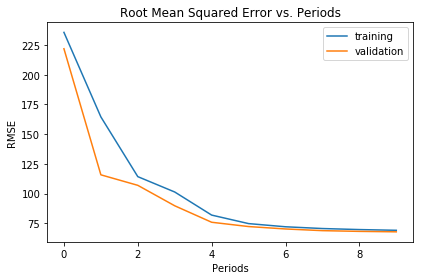

In [0]:
def normalize_linear_scale(examples_dataframe):
  """Returns a version of the input `DataFrame` that has all its features normalized linearly."""
  processed_features = pd.DataFrame()
  processed_features["latitude"] = linear_scale(examples_dataframe["latitude"])
  processed_features["longitude"] = linear_scale(examples_dataframe["longitude"])
  processed_features["housing_median_age"] = linear_scale(examples_dataframe["housing_median_age"])
  processed_features["total_rooms"] = linear_scale(examples_dataframe["total_rooms"])
  processed_features["total_bedrooms"] = linear_scale(examples_dataframe["total_bedrooms"])
  processed_features["population"] = linear_scale(examples_dataframe["population"])
  processed_features["households"] = linear_scale(examples_dataframe["households"])
  processed_features["median_income"] = linear_scale(examples_dataframe["median_income"])
  processed_features["rooms_per_person"] = linear_scale(examples_dataframe["rooms_per_person"])
  return processed_features

normalized_dataframe = normalize_linear_scale(preprocess_features(california_housing_dataframe))
normalized_training_examples = normalized_dataframe.head(12000)
normalized_validation_examples = normalized_dataframe.tail(5000)

_ = train_nn_regression_model(
    my_optimizer=tf.keras.optimizers.SGD(lr=0.003, clipnorm=5.),
    steps=2000,
    batch_size=50,
    hidden_units=[10,10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets,
    callbacks=[tf.keras.callbacks.TensorBoard(log_dir='improving_neural_network')])

## Task 2: Try a Different Optimizer

** Use the Adagrad and Adam optimizers and compare performance.**

The Adagrad optimizer is one alternative. The key insight of Adagrad is that it modifies the learning rate adaptively for each coefficient in a model, monotonically lowering the effective learning rate.  This works great for convex problems, but isn't always ideal for the non-convex problem Neural Net training.  You can use Adagrad by specifying `AdagradOptimizer` instead of `GradientDescentOptimizer`.  Note that you may need to use a larger learning rate with Adagrad.

For non-convex optimization problems, Adam is sometimes more efficient than Adagrad.  To use Adam, invoke the `tf.train.AdamOptimizer` method. This method takes several optional hyperparameters as arguments, but our solution only specifies one of these (`learning_rate`). In a production setting, you should specify and tune the optional hyperparameters carefully.

In [0]:
#
# YOUR CODE HERE: Retrain the network using Adagrad and then Adam.
#

### Solution

Click below for the solution

First, let's try Adagrad.

Train on 50 samples, validate on 5000 samples
50/50 [==============================] - 0s 8ms/step - loss: 112.7649 - mse: 13827.6123 - val_loss: 84.7159 - val_mse: 7229.9038
period 00 is finished
Train on 50 samples, validate on 5000 samples
50/50 [==============================] - 0s 6ms/step - loss: 79.8524 - mse: 6383.6318 - val_loss: 75.3313 - val_mse: 5750.6079
period 01 is finished
Train on 50 samples, validate on 5000 samples
50/50 [==============================] - 0s 6ms/step - loss: 74.9107 - mse: 5612.3135 - val_loss: 72.9204 - val_mse: 5381.6938
period 02 is finished
Train on 50 samples, validate on 5000 samples
50/50 [==============================] - 0s 6ms/step - loss: 73.1499 - mse: 5351.0820 - val_loss: 71.6164 - val_mse: 5209.9731
period 03 is finished
Train on 50 samples, validate on 5000 samples
50/50 [==============================] - 0s 6ms/step - loss: 72.1035 - mse: 5198.9780 - val_loss: 70.8427 - val_mse: 5099.2930
period 04 is finished
Train on 50 samples, va

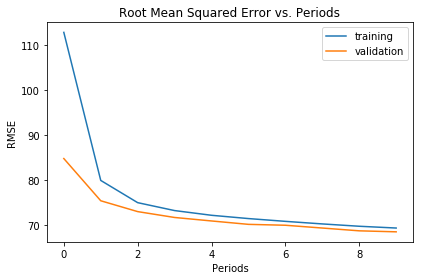

In [0]:
_, adagrad_training_losses, adagrad_validation_losses = train_nn_regression_model(
    my_optimizer=tf.keras.optimizers.Adagrad(lr=0.5, clipnorm=5.),
    steps=500,
    batch_size=100,
    hidden_units=[10,10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets,
    callbacks=[tf.keras.callbacks.TensorBoard(log_dir='improving_neural_network')])

Now let's try Adam.

Train on 50 samples, validate on 5000 samples
50/50 [==============================] - 0s 9ms/step - loss: 216.6816 - mse: 47353.9805 - val_loss: 162.9141 - val_mse: 26704.0273
period 00 is finished
Train on 50 samples, validate on 5000 samples
50/50 [==============================] - 0s 6ms/step - loss: 126.8984 - mse: 16296.7881 - val_loss: 112.4634 - val_mse: 12720.2061
period 01 is finished
Train on 50 samples, validate on 5000 samples
50/50 [==============================] - 0s 6ms/step - loss: 106.1122 - mse: 11287.5889 - val_loss: 94.4308 - val_mse: 8983.2070
period 02 is finished
Train on 50 samples, validate on 5000 samples
50/50 [==============================] - 0s 6ms/step - loss: 83.7412 - mse: 7061.8545 - val_loss: 72.3047 - val_mse: 5285.6553
period 03 is finished
Train on 50 samples, validate on 5000 samples
50/50 [==============================] - 0s 6ms/step - loss: 70.5626 - mse: 4979.8838 - val_loss: 68.5894 - val_mse: 4799.3022
period 04 is finished
Train on 50 sam

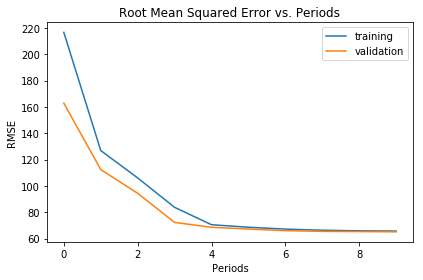

In [0]:
_, adam_training_losses, adam_validation_losses = train_nn_regression_model(
    my_optimizer=tf.keras.optimizers.Adam(lr=0.009, clipnorm=5.),
    steps=500,
    batch_size=100,
    hidden_units=[10,10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets,
    callbacks=[tf.keras.callbacks.TensorBoard(log_dir='improving_neural_network')])

Let's print a graph of loss metrics side by side.

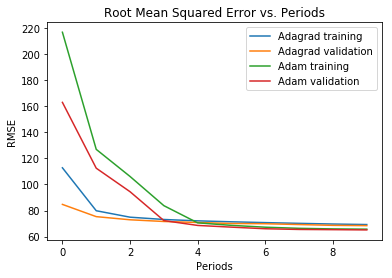

In [0]:
plt.ylabel("RMSE")
plt.xlabel("Periods")
plt.title("Root Mean Squared Error vs. Periods")
plt.plot(adagrad_training_losses, label='Adagrad training')
plt.plot(adagrad_validation_losses, label='Adagrad validation')
plt.plot(adam_training_losses, label='Adam training')
plt.plot(adam_validation_losses, label='Adam validation')
_ = plt.legend()

## Task 3: Explore Alternate Normalization Methods

**Try alternate normalizations for various features to further improve performance.**

If you look closely at summary stats for your transformed data, you may notice that linear scaling some features leaves them clumped close to `-1`.

For example, many features have a median of `-0.8` or so, rather than `0.0`.

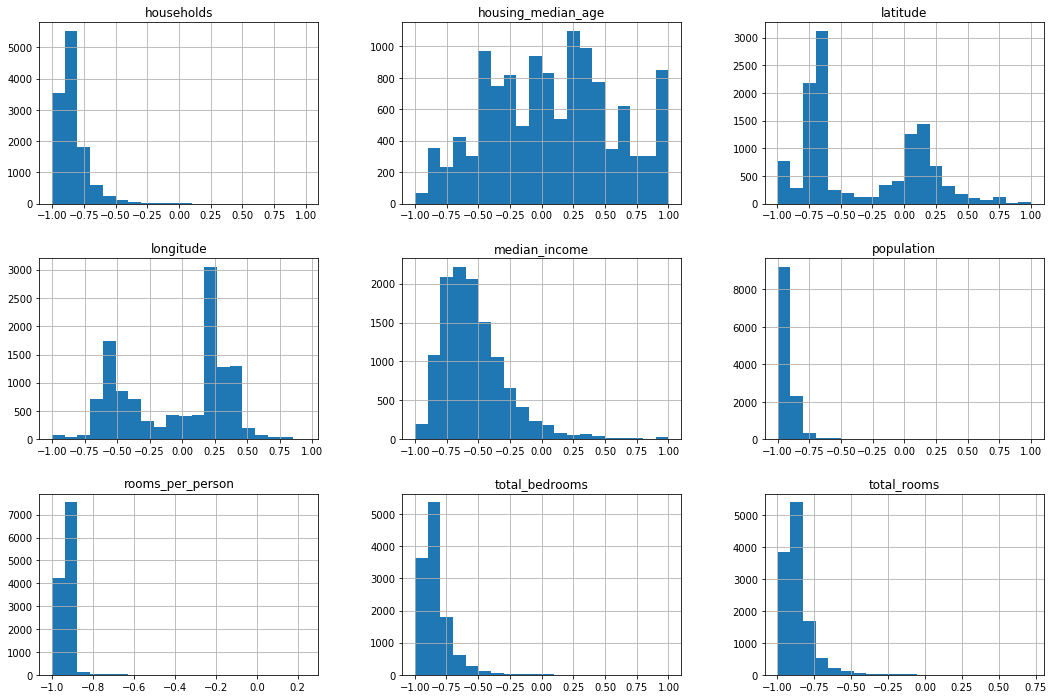

In [0]:
_ = normalized_training_examples.hist(bins=20, figsize=(18, 12), xlabelsize=10)

We might be able to do better by choosing additional ways to transform these features.

For example, a log scaling might help some features.  Or clipping extreme values may make the remainder of the scale more informative.

In [0]:
def log_normalize(series):
  return series.apply(lambda x:math.log(x+1.0))

def clip(series, clip_to_min, clip_to_max):
  return series.apply(lambda x:(
    min(max(x, clip_to_min), clip_to_max)))

def z_score_normalize(series):
  mean = series.mean()
  std_dv = series.std()
  return series.apply(lambda x:(x - mean) / std_dv)

def binary_threshold(series, threshold):
  return series.apply(lambda x:(1 if x > threshold else 0))

The block above contains a few additional possible normalization functions. Try some of these, or add your own.

Note that if you normalize the target, you'll need to un-normalize the predictions for loss metrics to be comparable.

In [0]:
def normalize(examples_dataframe):
  """Returns a version of the input `DataFrame` that has all its features normalized."""
  #
  # YOUR CODE HERE: Normalize the inputs.
  #
  pass

normalized_dataframe = normalize(preprocess_features(california_housing_dataframe))
normalized_training_examples = normalized_dataframe.head(12000)
normalized_validation_examples = normalized_dataframe.tail(5000)

_ = train_nn_regression_model(
    my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0007),
    steps=5000,
    batch_size=70,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

### Solution

Click below for one possible solution.

These are only a few ways in which we could think about the data. Other transformations may work even better!

`households`, `median_income` and `total_bedrooms` all appear normally-distributed in a log space.

`latitude`, `longitude` and `housing_median_age` would probably be better off just scaled linearly, as before.

`population`, `totalRooms` and `rooms_per_person` have a few extreme outliers. They seem too extreme for log normalization to help. So let's clip them instead.

Train on 100 samples, validate on 5000 samples
100/100 [==============================] - 1s 7ms/step - loss: 118.5045 - mse: 15460.6914 - val_loss: 85.9781 - val_mse: 7506.1519
period 00 is finished
Train on 100 samples, validate on 5000 samples
100/100 [==============================] - 1s 6ms/step - loss: 77.4764 - mse: 6015.2070 - val_loss: 74.0870 - val_mse: 5562.1011
period 01 is finished
Train on 100 samples, validate on 5000 samples
100/100 [==============================] - 1s 6ms/step - loss: 73.4546 - mse: 5395.7476 - val_loss: 72.4308 - val_mse: 5331.1416
period 02 is finished
Train on 100 samples, validate on 5000 samples
100/100 [==============================] - 1s 6ms/step - loss: 71.2509 - mse: 5077.3481 - val_loss: 69.7192 - val_mse: 4952.2578
period 03 is finished
Train on 100 samples, validate on 5000 samples
100/100 [==============================] - 1s 6ms/step - loss: 68.9560 - mse: 4755.1567 - val_loss: 68.0545 - val_mse: 4726.8779
period 04 is finished
Train on

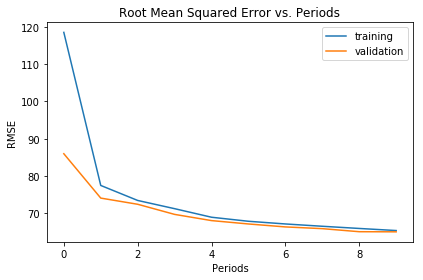

In [0]:
def normalize(examples_dataframe):
  """Returns a version of the input `DataFrame` that has all its features normalized."""
  processed_features = pd.DataFrame()

  processed_features["households"] = log_normalize(examples_dataframe["households"])
  processed_features["median_income"] = log_normalize(examples_dataframe["median_income"])
  processed_features["total_bedrooms"] = log_normalize(examples_dataframe["total_bedrooms"])
  
  processed_features["latitude"] = linear_scale(examples_dataframe["latitude"])
  processed_features["longitude"] = linear_scale(examples_dataframe["longitude"])
  processed_features["housing_median_age"] = linear_scale(examples_dataframe["housing_median_age"])

  processed_features["population"] = linear_scale(clip(examples_dataframe["population"], 0, 5000))
  processed_features["rooms_per_person"] = linear_scale(clip(examples_dataframe["rooms_per_person"], 0, 5))
  processed_features["total_rooms"] = linear_scale(clip(examples_dataframe["total_rooms"], 0, 10000))

  return processed_features

normalized_dataframe = normalize(preprocess_features(california_housing_dataframe))
normalized_training_examples = normalized_dataframe.head(12000)
normalized_validation_examples = normalized_dataframe.tail(5000)

_ = train_nn_regression_model(
    my_optimizer=tf.keras.optimizers.Adagrad(lr=0.15, clipnorm=5.),
    steps=1000,
    batch_size=50,
    hidden_units=[10,10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets,
    callbacks=[tf.keras.callbacks.TensorBoard(log_dir='improving_neural_network')])

## Optional Challenge: Use only Latitude and Longitude Features

**Train a NN model that uses only latitude and longitude as features.**

Real estate people are fond of saying that location is the only important feature in housing price.
Let's see if we can confirm this by training a model that uses only latitude and longitude as features.

This will only work well if our NN can learn complex nonlinearities from latitude and longitude.

**NOTE:** We may need a network structure that has more layers than were useful earlier in the exercise.

In [0]:
#
# YOUR CODE HERE: Train the network using only latitude and longitude
#

### Solution

Click below for a possible solution.

It's a good idea to keep latitude and longitude normalized:

Train on 50 samples, validate on 5000 samples
50/50 [==============================] - 1s 17ms/step - loss: 170.4655 - mse: 32151.3125 - val_loss: 106.4815 - val_mse: 11446.4434
period 00 is finished
Train on 50 samples, validate on 5000 samples
50/50 [==============================] - 0s 10ms/step - loss: 105.9465 - mse: 11226.8574 - val_loss: 101.5604 - val_mse: 10438.6445
period 01 is finished
Train on 50 samples, validate on 5000 samples
50/50 [==============================] - 0s 10ms/step - loss: 102.3887 - mse: 10483.8652 - val_loss: 99.6796 - val_mse: 10027.5635
period 02 is finished
Train on 50 samples, validate on 5000 samples
50/50 [==============================] - 0s 10ms/step - loss: 100.8854 - mse: 10177.9434 - val_loss: 98.4195 - val_mse: 9841.2900
period 03 is finished
Train on 50 samples, validate on 5000 samples
50/50 [==============================] - 0s 10ms/step - loss: 99.9644 - mse: 9992.9541 - val_loss: 97.6943 - val_mse: 9668.7148
period 04 is finished
Train o

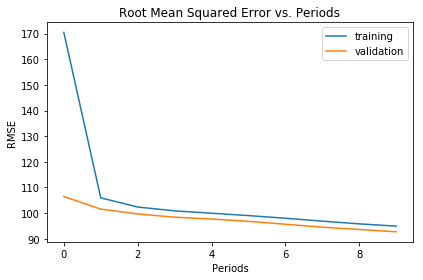

In [0]:
def location_location_location(examples_dataframe):
  """Returns a version of the input `DataFrame` that keeps only the latitude and longitude."""
  processed_features = pd.DataFrame()
  processed_features["latitude"] = linear_scale(examples_dataframe["latitude"])
  processed_features["longitude"] = linear_scale(examples_dataframe["longitude"])
  return processed_features

lll_dataframe = location_location_location(preprocess_features(california_housing_dataframe))
lll_training_examples = lll_dataframe.head(12000)
lll_validation_examples = lll_dataframe.tail(5000)

_ = train_nn_regression_model(
    my_optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.05, clipnorm=5.),
    steps=500,
    batch_size=50,
    hidden_units=[10, 10, 5, 5, 5],
    training_examples=lll_training_examples,
    training_targets=training_targets,
    validation_examples=lll_validation_examples,
    validation_targets=validation_targets,
    callbacks=[tf.keras.callbacks.TensorBoard(log_dir='improving_neural_network')])

This isn't too bad for just two features. Of course, property values can still vary significantly within short distances.